# Minimal Pipe Case
Various tests and diagnostics for analysing the minimal pipe flow dataset using Transfer Entropy (TE) methods

Kristaps Stolarovs, kristaps.stolarovs@manchester.ac.uk
___

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

import sys
sys.path.append('../core/')
from te import bi_te
from te import mv_te
from pseudoTE import pTE
import synData

import os
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm
import h5py

from matplotlib.colors import LinearSegmentedColormap

In [3]:
dir = '../data/min_pipe/'
data_min_symmetry = np.array(h5py.File(os.path.join(dir, 'T_coeff_11k.mat'), 'r')['T_coeff']).astype(np.float64).T
data_min = data_min_symmetry[len(data_min_symmetry)//2:, :]

In [4]:
print(data_min.shape)
print(data_min_symmetry.shape)

(11014, 100)
(22028, 100)


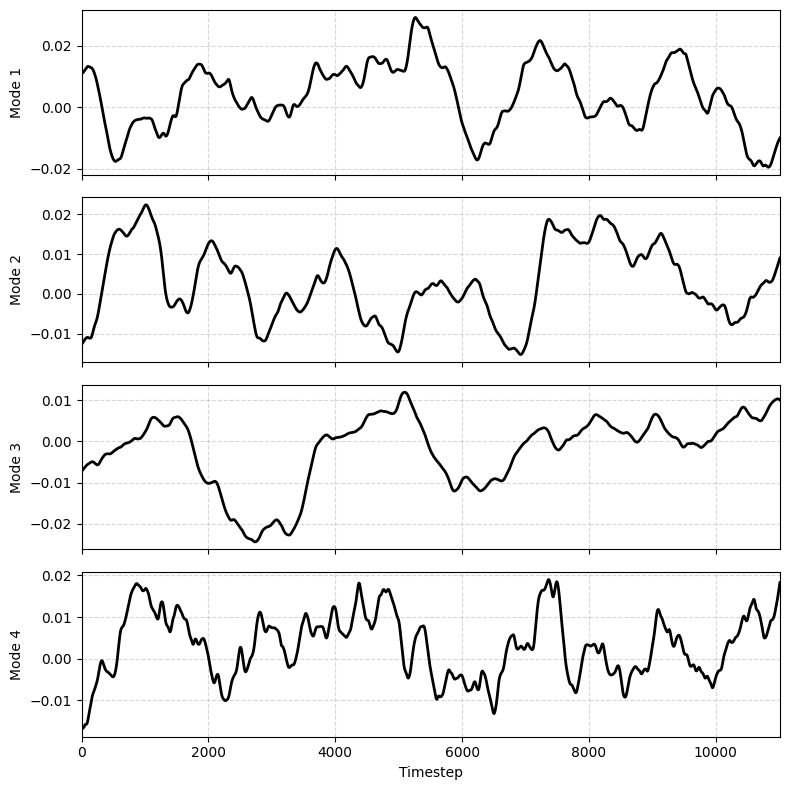

In [5]:
# First n modes
n_plots = 4
start = 1
fig, ax = plt.subplots(n_plots, 1, figsize=(8, 2*n_plots), sharex=True)

for i in range(n_plots):
    ax[i].plot(data_min[:, i+start], label=f'Mode {i+start}', color='black', linestyle='-', linewidth=2.0)
    ax[i].set_ylabel(f'Mode {i+start}')
    ax[i].grid(True, linestyle='--', alpha=0.5)
    if i == n_plots - 1:
        ax[i].set_xlabel('Timestep')

plt.xlim([0, 11014])

plt.tight_layout()
plt.show()

In [6]:
# TE Params
pod_modes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]#, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
modes = data_min[:5000, pod_modes]
num_pod = len(pod_modes)
num_var = modes.shape[1]

max_lag = 21
lagList = np.linspace(1, max_lag, max_lag).astype(int)
num_var = modes.shape[1]

all_pairs = list(itertools.product(range(num_var), repeat=2))

source_idx = [i for i, j in all_pairs if i != j]
target_idx = [j for i, j in all_pairs if i != j]

k_ = 70

In [7]:
# # save first 10 modes as pk
# with open(os.path.join(dir, 'min_pipe_10_11k.pkl'), 'wb') as f:
#     pickle.dump(modes, f)

In [ ]:
# Bivariate KSG
def ksg_single(lag_idx, lag, source_i, target_j, modes, k_):

    te_val = bi_te(modes[:, source_i], modes[:, target_j], lag).ksg(k=k_)
    
    return lag_idx, source_i, target_j, te_val

te_ksg = np.zeros((num_var, num_var, len(lagList)))

tasks = [
    (lag_idx, lag, i, j)
    for lag_idx, lag in enumerate(lagList)
    for i, j in zip(source_idx, target_idx)
]

results = Parallel(n_jobs=-1)(
    delayed(ksg_single)(lag_idx, lag, source_i, target_j, modes, k_)
    for lag_idx, lag, source_i, target_j in tqdm(tasks, desc='Computing bivariate TE', unit='pair', total=len(tasks))
)

for lag_idx, source_i, target_j, te_val in results:
    te_ksg[source_i, target_j, lag_idx] = te_val

In [ ]:
# pickle bivariate TE
with open(os.path.join(dir, 'te_ksg_bivariate.pkl'), 'wb') as f:
    pickle.dump(te_ksg, f)

In [8]:
# load bivariate TE
with open(os.path.join(dir, 'te_ksg_bivariate.pkl'), 'rb') as f:
    te_ksg = pickle.load(f)

In [ ]:
# Multivariate KSG
def mksg_single(lag_idx, lag, target_i, X_, modes, k_, num_var):
    
    teDict = mv_te(X=X_, y=modes[:,target_i], embDim=lag).ntwrk_ksg(k=k_)
    
    te_val = np.zeros(num_var)
    for src in range(num_var):
        if src != target_i:  # Skip self-connection
            key = f'TE{src}->y'
            if key in teDict:
                te_val[src] = teDict[key]
                
    key_all = f'TE_all->y'
    te_all = teDict[key_all]
    
    return lag_idx, target_i, te_val, te_all

# Setup for parallel computation
mte_ksg = np.zeros((num_var, num_var, len(lagList)))
mte_ksg_all = np.zeros((num_var, len(lagList)))
X_ = [modes[:, i] for i in range(num_var)]

tasks = [(lag_idx, lag, i) for lag_idx, lag in enumerate(lagList) for i in target_idx]

# Parallel computation of multivariate KSG
results = Parallel(n_jobs=12)(
    delayed(mksg_single)(lag_idx, lag, target_i, X_, modes, k_, num_var)
    for lag_idx, lag, target_i in tqdm(tasks, desc="Computing multivariate TE")
    # for lag_idx, lag, target_i in tasks
)

for lag_idx, target_i, te_values, te_all in results:
    mte_ksg[:, target_i, lag_idx] = te_values
    mte_ksg_all[target_i, lag_idx] = te_all

In [ ]:
# pickle multivariate TE
with open(os.path.join(dir, 'te_ksg_multivariate.pkl'), 'wb') as f:
    pickle.dump(mte_ksg, f)
with open(os.path.join(dir, 'te_ksg_multivariate_all.pkl'), 'wb') as f:
    pickle.dump(mte_ksg_all, f)

In [9]:
# load multivariate TE
with open(os.path.join(dir, 'te_ksg_multivariate.pkl'), 'rb') as f:
    mte_ksg = pickle.load(f)
with open(os.path.join(dir, 'te_ksg_multivariate_all.pkl'), 'rb') as f:
    mte_ksg_all = pickle.load(f)

In [ ]:
# pickle results
with open(os.path.join(dir, 'min_pipe_11k_10.pkl'), 'wb') as f:
    pickle.dump({
        'te_ksg': te_ksg,
        'mte_ksg': mte_ksg,
        'mte_ksg_all': mte_ksg_all,
        'lagList': lagList,
        'pod_modes': pod_modes,
        'modes': modes,
    }, f)

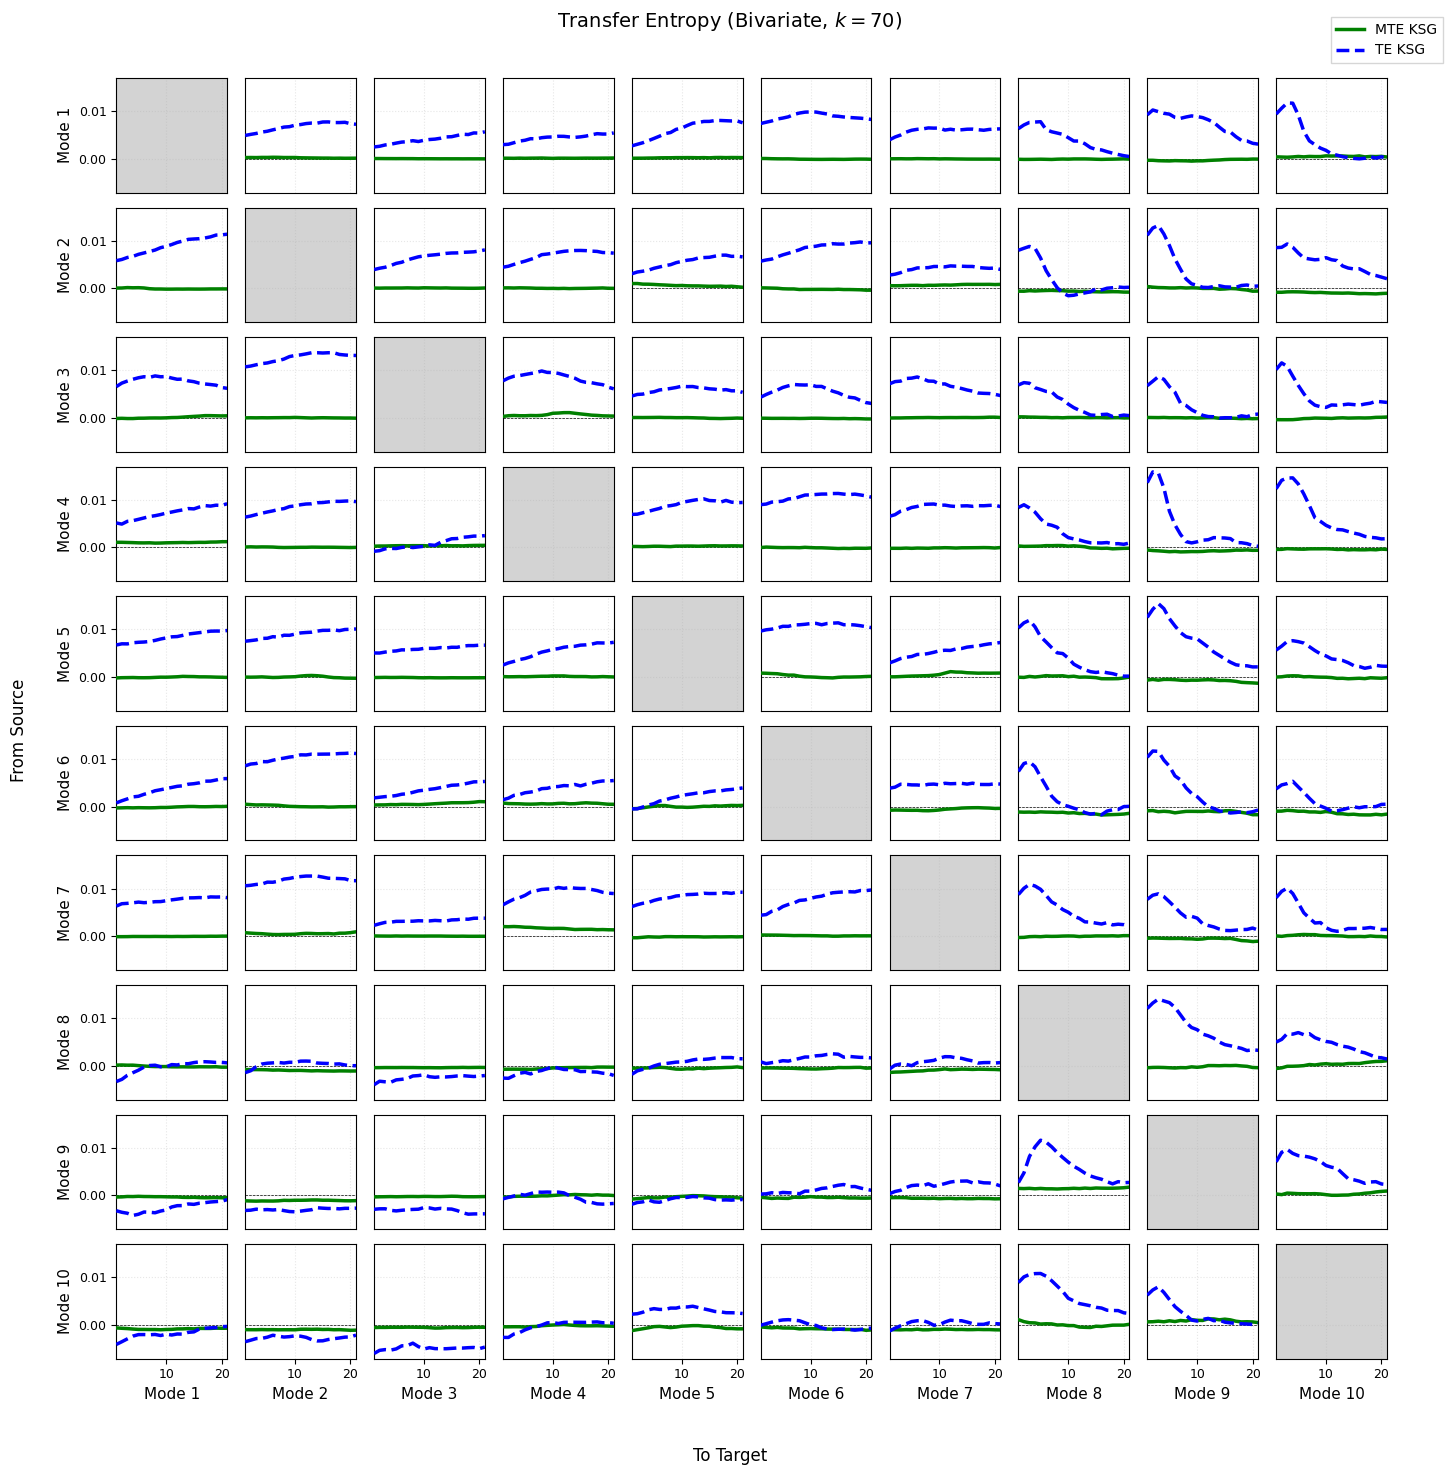

In [10]:
x_lags = np.arange(1, max_lag + 1)
fig, axis = plt.subplots(num_pod, num_pod, 
                        figsize=(num_pod*1.5, num_pod*1.5),
                        sharex=True, sharey=True)

# Create legend elements
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', linewidth=2.5, label='MTE KSG'),
    Line2D([0], [0], color='blue', linewidth=2.5, linestyle='--', label='TE KSG')
]

for i in range(num_pod):
    for j in range(num_pod):
        ax = axis[i, j]
        
        if i == j:
            ax.set_facecolor('lightgrey')
        else:
            ax.plot(x_lags, mte_ksg[i,j,:], 
                   color='green', linewidth=2.5, zorder=10)
            ax.plot(x_lags, te_ksg[i,j,:], 
                   color='blue', linestyle='--', linewidth=2.5, zorder=10)
            # horizontal line at zero
            ax.axhline(0, color='black', linewidth=0.5, linestyle='--', zorder=5)
        
        ax.set_xlim([1, max_lag])
        
        # left col
        if j == 0:
            ax.tick_params(axis='y', which='both', left=True, right=False, 
                          labelleft=True, labelright=False, labelsize=9)
            ax.set_ylabel(f'Mode {pod_modes[i]}', fontsize=11)
        else:
            ax.tick_params(axis='y', which='both', left=False, right=False, 
                          labelleft=False, labelright=False)
        
        # bottom row
        if i == num_pod - 1:
            ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                          labelbottom=True, labeltop=False, labelsize=9)
            ax.set_xlabel(f'Mode {pod_modes[j]}', fontsize=11)
        else:
            ax.tick_params(axis='x', which='both', bottom=False, top=False, 
                          labelbottom=False, labeltop=False)
        ax.grid(True, linestyle=':', alpha=0.3, zorder=0)

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
           fontsize=10, frameon=True, fancybox=False, shadow=False)

fig.supylabel('From Source', fontsize=12)
fig.supxlabel('To Target', fontsize=12)
fig.suptitle(rf'Transfer Entropy (Bivariate, $k={str(k_)}$)', fontsize=14)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.97])  # [left, bottom, right, top]
plt.show()

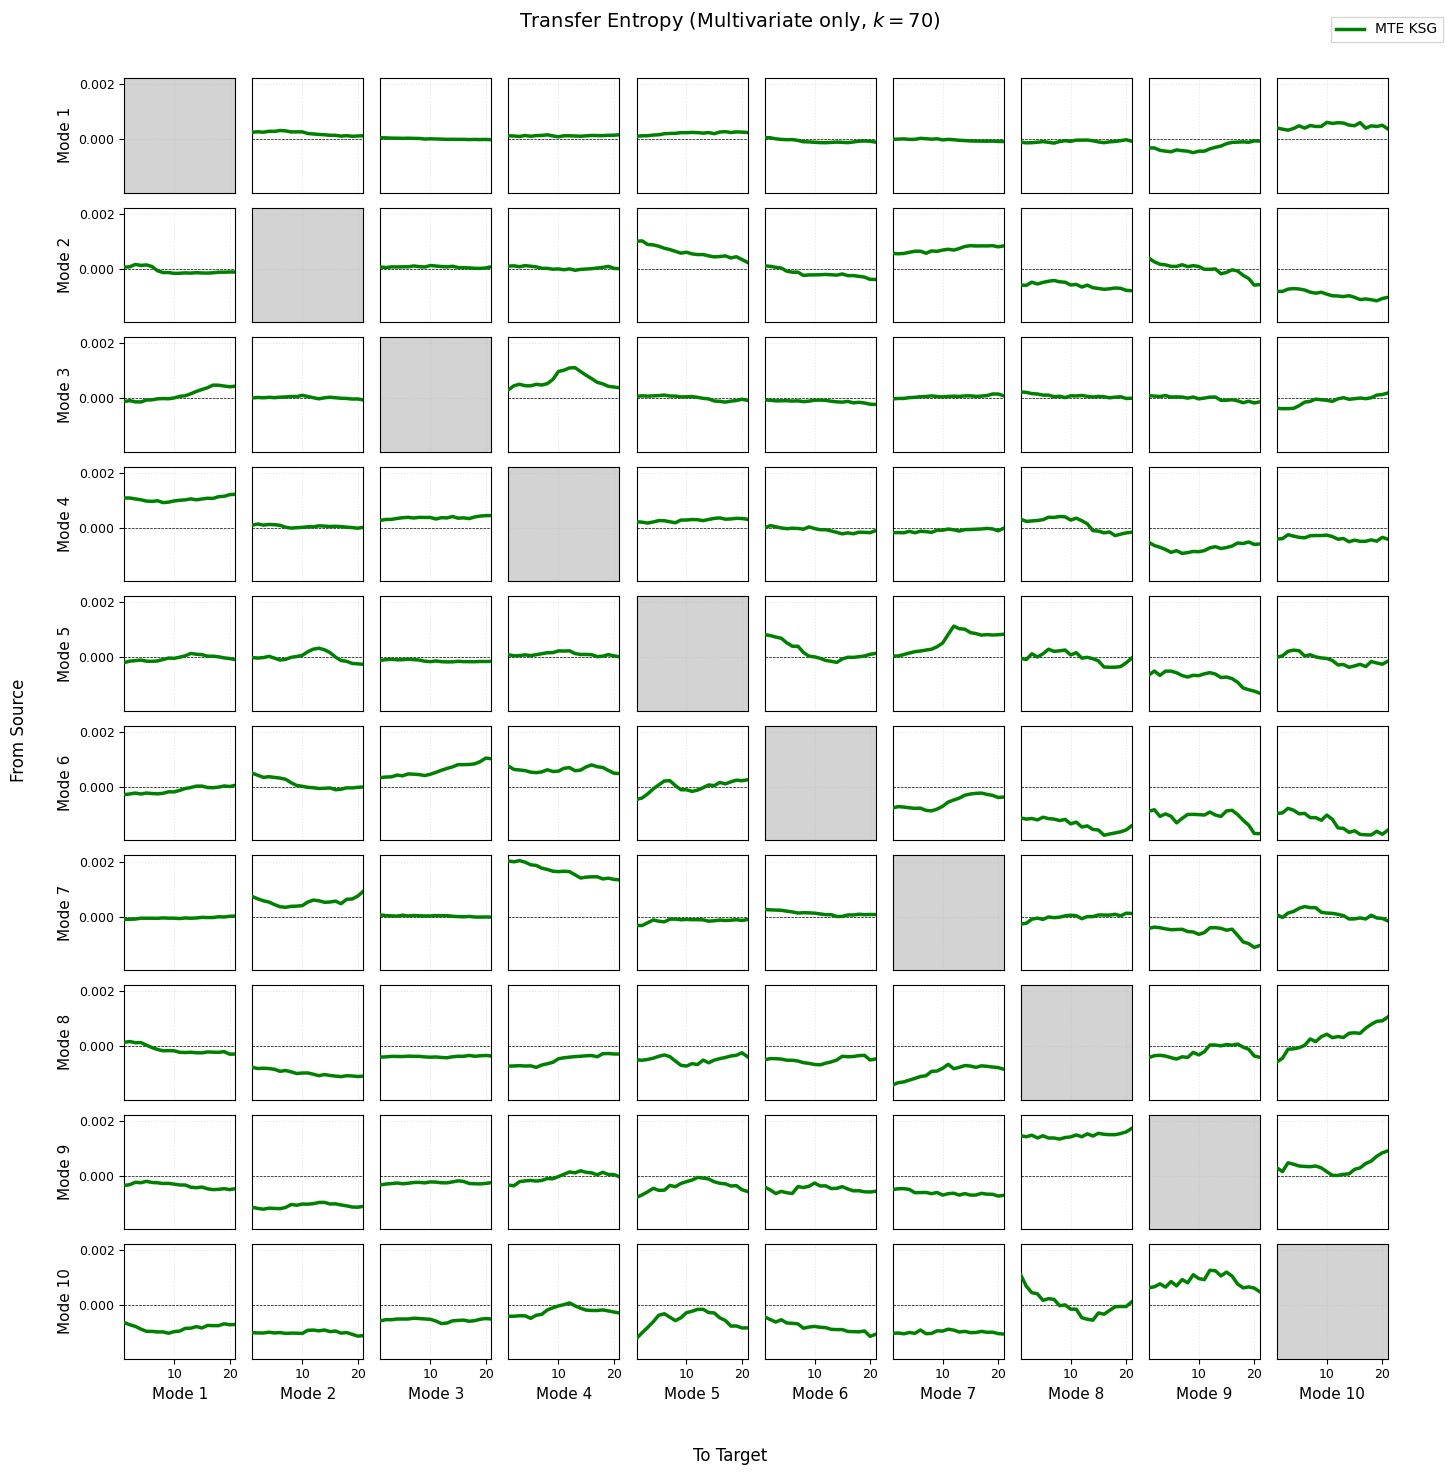

In [11]:
x_lags = np.arange(1, max_lag + 1)
fig, axis = plt.subplots(num_pod, num_pod, 
                        figsize=(num_pod*1.5, num_pod*1.5),
                        sharex=True, sharey=True)

# Create legend elements
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', linewidth=2.5, label='MTE KSG'),
    # Line2D([0], [0], color='blue', linewidth=2.5, linestyle='--', label='TE KSG')
]

for i in range(num_pod):
    for j in range(num_pod):
        ax = axis[i, j]
        
        if i == j:
            ax.set_facecolor('lightgrey')
        else:
            ax.plot(x_lags, mte_ksg[i,j,:], 
                   color='green', linewidth=2.5, zorder=10)
            # ax.plot(x_lags, te_ksg[i,j,:], 
            #        color='blue', linestyle='--', linewidth=2.5, zorder=10)
            # horizontal line at zero
            ax.axhline(0, color='black', linewidth=0.5, linestyle='--', zorder=5)
        
        ax.set_xlim([1, max_lag])
        
        # left col
        if j == 0:
            ax.tick_params(axis='y', which='both', left=True, right=False, 
                          labelleft=True, labelright=False, labelsize=9)
            ax.set_ylabel(f'Mode {pod_modes[i]}', fontsize=11)
        else:
            ax.tick_params(axis='y', which='both', left=False, right=False, 
                          labelleft=False, labelright=False)
        
        # bottom row
        if i == num_pod - 1:
            ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                          labelbottom=True, labeltop=False, labelsize=9)
            ax.set_xlabel(f'Mode {pod_modes[j]}', fontsize=11)
        else:
            ax.tick_params(axis='x', which='both', bottom=False, top=False, 
                          labelbottom=False, labeltop=False)
        ax.grid(True, linestyle=':', alpha=0.3, zorder=0)

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
           fontsize=10, frameon=True, fancybox=False, shadow=False)

fig.supylabel('From Source', fontsize=12)
fig.supxlabel('To Target', fontsize=12)
fig.suptitle(rf'Transfer Entropy (Multivariate only, $k={str(k_)}$)', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.97])  # [left, bottom, right, top]
plt.show()

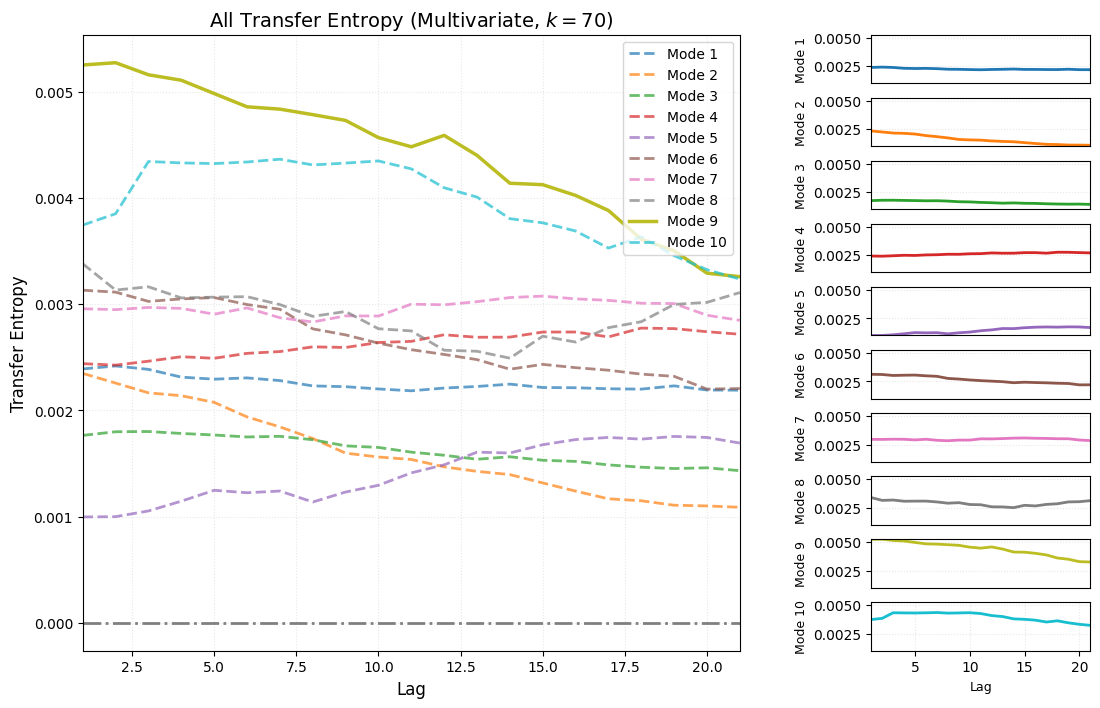

In [12]:
# Create figure and grid layout
ylim = [mte_ksg_all.min(), mte_ksg_all.max()]

# find idx of max mode
max_mode_vals = np.zeros(num_pod)
for i in range(num_pod):
    max_mode_vals[i] = np.max(np.abs(mte_ksg_all[i, :]))

max_mode_idx = np.argmax(max_mode_vals)

fig = plt.figure(figsize=(13, num_pod*0.8))

gs = gridspec.GridSpec(num_pod, 2, 
                       width_ratios=[3, 1],  # Left column twice as wide as right
                       hspace=0.3, wspace=0.3)

# left col
ax_combined = fig.add_subplot(gs[:, 0])  # Span all rows in left column

colors = plt.cm.tab10(np.linspace(0, 1, num_pod))
for i in range(num_pod):
    if i == max_mode_idx:
        ax_combined.plot(x_lags, mte_ksg_all[i, :], 
                        label=f'Mode {pod_modes[i]}', 
                        color=colors[i], linewidth=2.5)
    else:
        ax_combined.plot(x_lags, mte_ksg_all[i, :], 
                        label=f'Mode {pod_modes[i]}', 
                        color=colors[i], linewidth=2,
                        linestyle='--', alpha=0.7)

ax_combined.axhline(0, color='grey', linewidth=2, linestyle='-.')
ax_combined.set_xlim([1, max_lag])
ax_combined.set_xlabel('Lag', fontsize=12)
ax_combined.set_ylabel('Transfer Entropy', fontsize=12)
ax_combined.set_title(rf'All Transfer Entropy (Multivariate, $k={str(k_)}$)', fontsize=14)
ax_combined.legend(loc='upper right')
ax_combined.grid(True, linestyle=':', alpha=0.3)

# right col
for i in range(num_pod):

    ax_individual = fig.add_subplot(gs[i, 1])

    ax_individual.plot(x_lags, mte_ksg_all[i, :], 
                    color=colors[i], linewidth=2)

    ax_individual.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax_individual.set_xlim([1, max_lag])
    ax_individual.set_ylim(ylim)
    ax_individual.set_ylabel(f'Mode {pod_modes[i]}', fontsize=9)
    ax_individual.grid(True, linestyle=':', alpha=0.3)
    
    # Remove x-axis labels except for bottom plot
    if i < num_pod - 1:
        ax_individual.set_xticks([])
    else:
        ax_individual.set_xlabel('Lag', fontsize=9)

# plt.tight_layout()
plt.show()

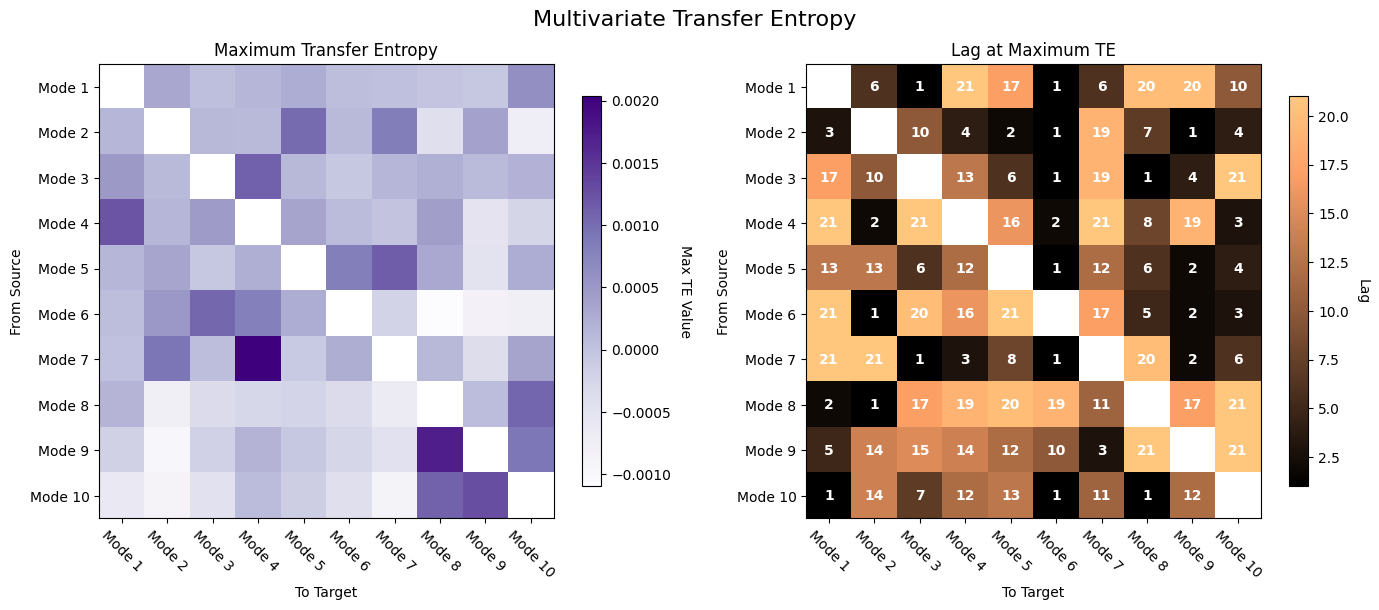

In [13]:
# Compute max TE values and corresponding lags
max_te_values = np.max(mte_ksg, axis=2)
max_te_lags = np.argmax(mte_ksg, axis=2) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mask diagonal
max_te_masked = max_te_values.copy()
max_lag_masked = max_te_lags.astype(float).copy()
np.fill_diagonal(max_te_masked, np.nan)
np.fill_diagonal(max_lag_masked, np.nan)

# Left plot - TE magnitude
im1 = ax1.imshow(max_te_masked, cmap='Purples', aspect='equal')
ax1.set_title('Maximum Transfer Entropy')
ax1.set_xlabel('To Target')
ax1.set_ylabel('From Source')
ax1.set_xticks(range(num_pod))
ax1.set_yticks(range(num_pod))
ax1.set_xticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)], rotation=-45)
ax1.set_yticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)])
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Max TE Value', rotation=270, labelpad=15)

# Right plot - Lag at maximum
im2 = ax2.imshow(max_lag_masked, cmap='copper', aspect='equal', vmin=1, vmax=max_lag)
ax2.set_title('Lag at Maximum TE')
ax2.set_xlabel('To Target')
ax2.set_ylabel('From Source')
ax2.set_xticks(range(num_pod))
ax2.set_yticks(range(num_pod))
ax2.set_xticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)], rotation=-45)
ax2.set_yticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)])
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Lag', rotation=270, labelpad=15)

# text annotations
for i in range(num_pod):
    for j in range(num_pod):
        if i != j and not np.isnan(max_lag_masked[i, j]):
            ax2.text(j, i, f'{max_lag_masked[i, j]:.0f}', 
                    ha="center", va="center", color='white', fontweight='bold')

fig.suptitle('Multivariate Transfer Entropy', fontsize=16)
plt.tight_layout()
plt.show()

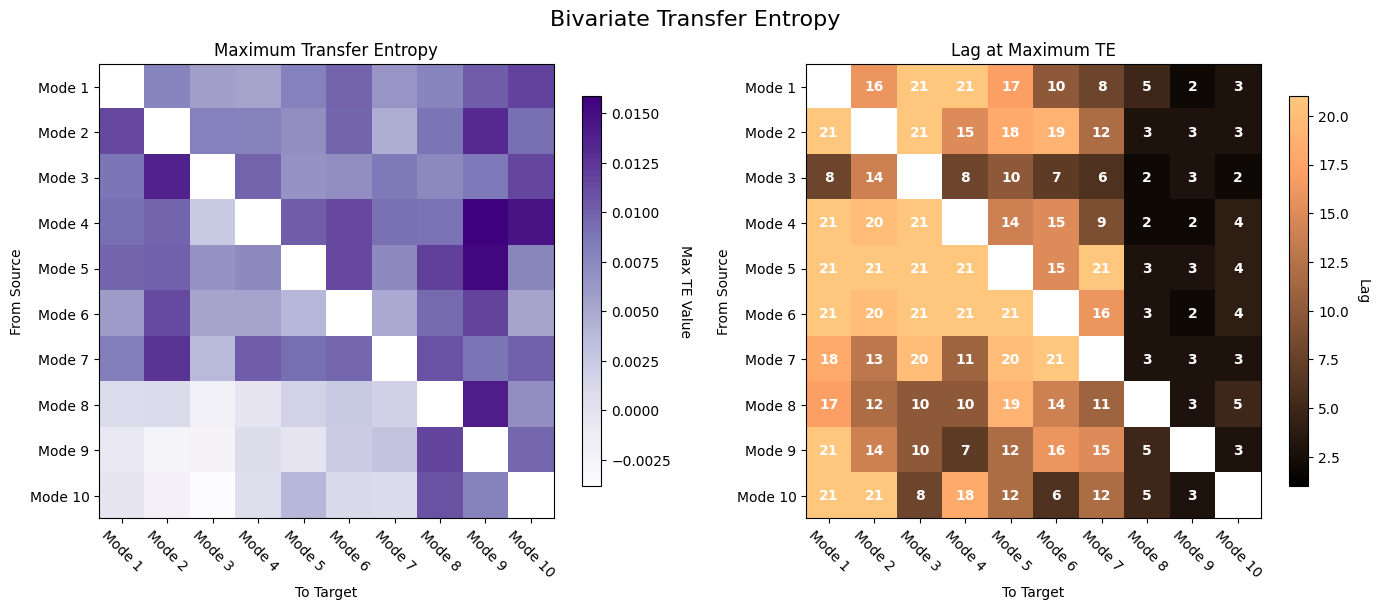

In [14]:
# Compute max TE values and corresponding lags
max_te_values = np.max(te_ksg, axis=2)
max_te_lags = np.argmax(te_ksg, axis=2) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Mask diagonal
max_te_masked = max_te_values.copy()
max_lag_masked = max_te_lags.astype(float).copy()
np.fill_diagonal(max_te_masked, np.nan)
np.fill_diagonal(max_lag_masked, np.nan)

# Left plot - TE magnitude
im1 = ax1.imshow(max_te_masked, cmap='Purples', aspect='equal')
ax1.set_title('Maximum Transfer Entropy')
ax1.set_xlabel('To Target')
ax1.set_ylabel('From Source')
ax1.set_xticks(range(num_pod))
ax1.set_yticks(range(num_pod))
ax1.set_xticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)], rotation=-45)
ax1.set_yticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)])
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Max TE Value', rotation=270, labelpad=15)

# Right plot - Lag at maximum
im2 = ax2.imshow(max_lag_masked, cmap='copper', aspect='equal', vmin=1, vmax=max_lag)
ax2.set_title('Lag at Maximum TE')
ax2.set_xlabel('To Target')
ax2.set_ylabel('From Source')
ax2.set_xticks(range(num_pod))
ax2.set_yticks(range(num_pod))
ax2.set_xticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)], rotation=-45)
ax2.set_yticklabels([f'Mode {pod_modes[i]}' for i in range(num_pod)])
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Lag', rotation=270, labelpad=15)

# text annotations
for i in range(num_pod):
    for j in range(num_pod):
        if i != j and not np.isnan(max_lag_masked[i, j]):
            ax2.text(j, i, f'{max_lag_masked[i, j]:.0f}', 
                    ha="center", va="center", color='white', fontweight='bold')

fig.suptitle('Bivariate Transfer Entropy', fontsize=16)
plt.tight_layout()
plt.show()

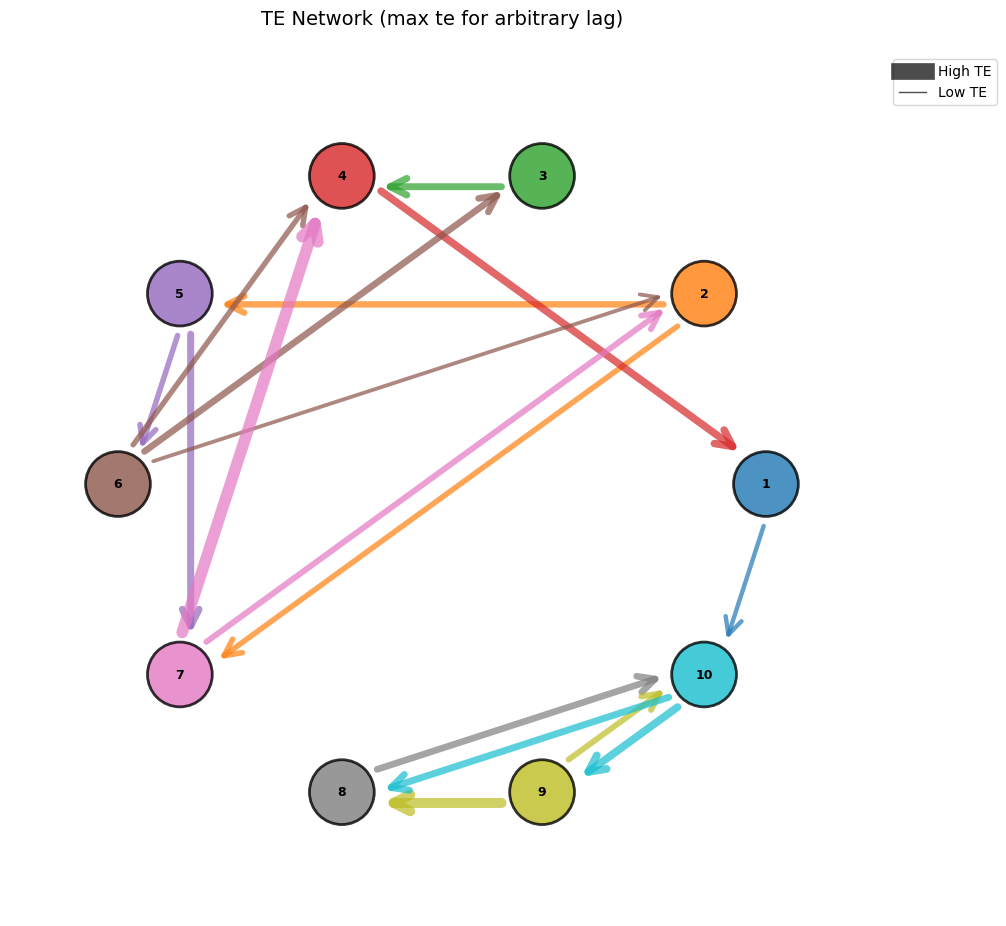

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.patches as mpatches

# Circular Layout Network Diagram
fig, ax = plt.subplots(figsize=(10, 10))

colors = plt.cm.tab10(np.linspace(0, 1, num_pod))

te_summary = np.max(mte_ksg, axis=2)

# Node positions in circle
angles = np.linspace(0, 2*np.pi, num_pod, endpoint=False)
radius = 3
node_positions = [(radius * np.cos(angle), radius * np.sin(angle)) for angle in angles]

# Draw nodes
node_radius = 0.3
for i, (x, y) in enumerate(node_positions):
    circle = Circle((x, y), node_radius, color=colors[i], ec='black', linewidth=2, zorder=10, alpha=0.8)
    ax.add_patch(circle)
    ax.text(x, y, pod_modes[i], ha='center', va='center', fontsize=9, fontweight='bold', zorder=11)

# Normalize arrow thickness
max_te = np.max(te_summary)
min_te = np.min(te_summary[te_summary > 0])  # Exclude zeros
min_thickness = 1
max_thickness = 12
# threshold = np.mean(te_summary) * 1.5  # Only show meaningful connections? But what is meaningful??
threshold = 0.0005

# Draw arrows
for i in range(num_pod):
    for j in range(num_pod):
        if i != j:  # No self-loops
            te_val = te_summary[i, j]
            
            # Only draw arrow if above threshold
            if te_val > threshold:
                x1, y1 = node_positions[i]
                x2, y2 = node_positions[j]
                
                # calculate thickness based on TE value
                if max_te > min_te:
                    thickness = min_thickness + ((te_val - min_te) / (max_te - min_te)) * (max_thickness - min_thickness)/1.5
                else:
                    thickness = min_thickness
                
                # small offset to make arrows more visible
                offset = 0.1
                dx, dy = x2 - x1, y2 - y1
                length = np.sqrt(dx**2 + dy**2)
                perp_x, perp_y = -dy/length * offset, dx/length * offset

                start_x = x1 + (dx/length) * (node_radius + 0.05) + perp_x
                start_y = y1 + (dy/length) * (node_radius + 0.05) + perp_y
                end_x = x2 - (dx/length) * (node_radius + 0.05) + perp_x
                end_y = y2 - (dy/length) * (node_radius + 0.05) + perp_y
                
                arrow = FancyArrowPatch(
                    (start_x, start_y), (end_x, end_y),
                    arrowstyle='->', 
                    linewidth=thickness,
                    color=colors[i],
                    alpha=0.7,
                    mutation_scale=30,
                    zorder=5
                )
                ax.add_patch(arrow)

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
ax.axis('off')

legend_elements = [
    plt.Line2D([0], [0], color='black', linewidth=max_thickness, alpha=0.7, label=f'High TE'),
    plt.Line2D([0], [0], color='black', linewidth=min_thickness, alpha=0.7, label=f'Low TE')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

title = f'TE Network (max te for arbitrary lag)'

ax.set_title(title, fontsize=14, pad=20)

plt.tight_layout()
plt.show()

In [8]:
# robustness study
    
k_ = 20
lagList = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
patch_size = 3000
patch_num = 20
patch_src = [1]
patch_tgt = [2]    

# setup patches
patch_mode = data_min[:, [patch_src[0], patch_tgt[0]]]

patches_src = np.zeros((patch_num, patch_size))
patches_tgt = np.zeros((patch_num, patch_size))
patch_indices = np.zeros(patch_num, dtype=int)

np.random.seed(42)
for i in range(patch_num):
    patch_indices[i] = np.random.randint(0, len(patch_mode)-patch_size)
    
# sort patches
patch_indices = np.sort(patch_indices)

for i in range(patch_num):
    patches_src[i, :] = patch_mode[patch_indices[i]:patch_indices[i]+patch_size, 0]
    patches_tgt[i, :] = patch_mode[patch_indices[i]:patch_indices[i]+patch_size, 1]



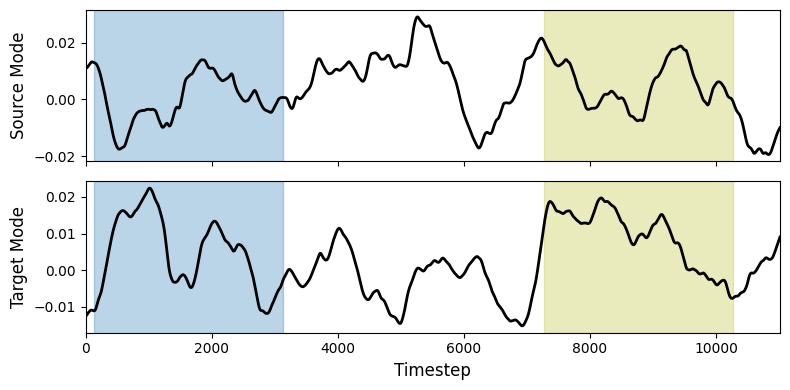

In [9]:
# plot selected patches
# plt.figure(figsize=(10, 3))
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax[0].plot(patch_mode[:,0], label='Source Mode', color='black', linestyle='-', linewidth=2.0)
ax[1].plot(patch_mode[:,1], label='Target Mode', color='black', linestyle='-', linewidth=2.0)

ax[0].set_ylabel('Source Mode', fontsize=12)
ax[1].set_ylabel('Target Mode', fontsize=12)
ax[1].set_xlabel('Timestep', fontsize=12)

colors = plt.cm.tab10(np.linspace(0, 1, patch_num))
# colors = ['blue', 'red']
for i in [0, 17]:
    ax[0].axvspan(patch_indices[i], patch_indices[i] + patch_size,
                  color=colors[i], alpha=0.3, label=f'Patch {i+1}')
    ax[1].axvspan(patch_indices[i], patch_indices[i] + patch_size,
                  color=colors[i], alpha=0.3)

plt.xlim([0, 11014])

plt.tight_layout()
plt.show()

In [10]:
# study 1: Paired patches - source[i] with target[i]
def ksg_paired(patch_idx, lag_idx, lag, source_patch, target_patch, k_):
    te_val = bi_te(source_patch, target_patch, lag).ksg(k=k_)
    return patch_idx, lag_idx, te_val

tasks_study1 = [
    (patch_idx, lag_idx, lag, patches_src[patch_idx], patches_tgt[patch_idx], k_)
    for patch_idx in range(patch_num)
    for lag_idx, lag in enumerate(lagList)
]

results_study1 = Parallel(n_jobs=-1)(
    delayed(ksg_paired)(patch_idx, lag_idx, lag, src_patch, tgt_patch, k_)
    for patch_idx, lag_idx, lag, src_patch, tgt_patch, k_ in tqdm(tasks_study1, desc='Study 1: Paired patches', unit='task')
)

te_paired = np.zeros((patch_num, len(lagList)))
for patch_idx, lag_idx, te_val in results_study1:
    te_paired[patch_idx, lag_idx] = te_val

Study 1: Paired patches: 100%|██████████| 200/200 [00:38<00:00,  5.15task/s]


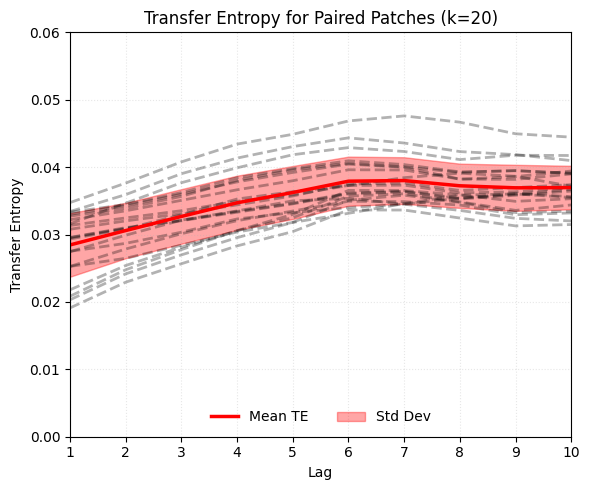

In [14]:
# plot of lag vs TE for paired patches
plt.figure(figsize=(6, 5))
alphas = np.linspace(0.2, 1, patch_num)
for patch_idx in range(patch_num):
    plt.plot(lagList, te_paired[patch_idx, :], linewidth=2.0, 
             alpha=0.3, linestyle='--',
             color='black')
    
# plot mean TE
mean_te = np.mean(te_paired, axis=0)
plt.plot(lagList, mean_te, label='Mean TE', color='red', linewidth=2.5, linestyle='-')

# plot standard deviation
std_te = np.std(te_paired, axis=0)
plt.fill_between(lagList, mean_te - std_te, mean_te + std_te,
                 color='red', alpha=0.35, label='Std Dev')
    
plt.xlabel('Lag')
plt.ylabel('Transfer Entropy')

plt.xlim([1, 10])
plt.ylim([0, 0.06])

plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(ncols=4, fancybox=False, frameon=False, fontsize=10, loc='lower center')

plt.title(f'Transfer Entropy for Paired Patches (k={k_})')
plt.tight_layout()
plt.show()

In [15]:
# study 2: Matrix patches - source[i] with target[j] for all i, j
def ksg_matrix(src_idx, tgt_idx, lag_idx, lag, source_patch, target_patch, k_):
    te_val = bi_te(source_patch, target_patch, lag).ksg(k=k_)
    return src_idx, tgt_idx, lag_idx, te_val

tasks_study2 = [
    (src_idx, tgt_idx, lag_idx, lag, patches_src[src_idx], patches_tgt[tgt_idx], k_)
    for src_idx in range(patch_num)
    for tgt_idx in range(patch_num)
    for lag_idx, lag in enumerate(lagList)
]

results_study2 = Parallel(n_jobs=-1)(
    delayed(ksg_matrix)(src_idx, tgt_idx, lag_idx, lag, src_patch, tgt_patch, k_)
    for src_idx, tgt_idx, lag_idx, lag, src_patch, tgt_patch, k_ in tqdm(tasks_study2, desc='Study 2: Matrix patches', unit='task')
)

te_matrix = np.zeros((patch_num, patch_num, len(lagList)))
for src_idx, tgt_idx, lag_idx, te_val in results_study2:
    te_matrix[src_idx, tgt_idx, lag_idx] = te_val

Study 2: Matrix patches: 100%|██████████| 4000/4000 [17:12<00:00,  3.87task/s]


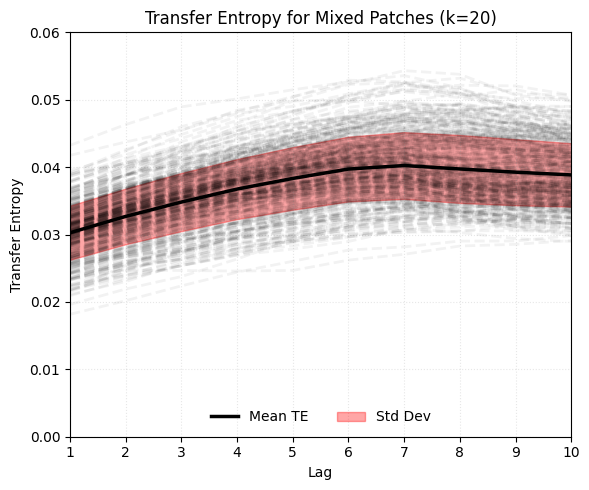

In [16]:
# plot of lag vs TE for mixed patches
plt.figure(figsize=(6, 5))
alphas = np.linspace(0.2, 1, patch_num)
for src_idx in range(patch_num):
    for tgt_idx in range(patch_num):
        if src_idx != tgt_idx:  # Skip self-connections
            plt.plot(lagList, te_matrix[src_idx, tgt_idx, :], linewidth=2.0, 
                    alpha=0.05, linestyle='--',
                    color='black')

# plot mean TE
mean_te = np.mean(te_matrix, axis=(0, 1))
plt.plot(lagList, mean_te, label='Mean TE', color='black', linewidth=2.5, linestyle='-')
# plot standard deviation
std_te = np.std(te_matrix, axis=(0, 1))
plt.fill_between(lagList, mean_te - std_te, mean_te + std_te,
                 color='red', alpha=0.35, label='Std Dev')

plt.xlabel('Lag')
plt.ylabel('Transfer Entropy')
plt.xlim([1, 10])
plt.ylim([0, 0.06])
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(ncols=4, fancybox=False, frameon=False, fontsize=10, loc='lower center')
plt.title(f'Transfer Entropy for Mixed Patches (k={k_})')
plt.tight_layout()
plt.show()

Minimum TE patch pair: Source 6 with Target 19 at Lag 1 - TE: 0.0182
Maximum TE patch pair: Source 16 with Target 1 at Lag 7 - TE: 0.0543


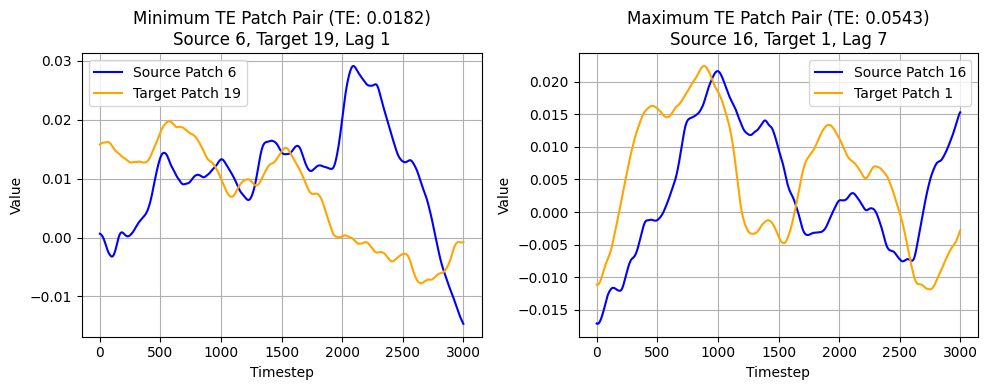

In [36]:
# plot the minimum and maximum TE value patch pairs
min_te_idx = np.unravel_index(np.argmin(te_matrix, axis=None), te_matrix.shape)
max_te_idx = np.unravel_index(np.argmax(te_matrix, axis=None), te_matrix.shape)
print(f"Minimum TE patch pair: Source {min_te_idx[0]+1} with Target {min_te_idx[1]+1} at Lag {lagList[min_te_idx[2]]} - TE: {te_matrix[min_te_idx]:.4f}")
print(f"Maximum TE patch pair: Source {max_te_idx[0]+1} with Target {max_te_idx[1]+1} at Lag {lagList[max_te_idx[2]]} - TE: {te_matrix[max_te_idx]:.4f}")
import matplotlib.pyplot as plt
import numpy as np
# Plot the minimum TE patch pair
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(patches_src[min_te_idx[0]], label=f'Source Patch {min_te_idx[0]+1}', color='blue')
plt.plot(patches_tgt[min_te_idx[1]], label=f'Target Patch {min_te_idx[1]+1}', color='orange')
plt.title(f'Minimum TE Patch Pair (TE: {te_matrix[min_te_idx]:.4f})\n'
          f'Source {min_te_idx[0]+1}, Target {min_te_idx[1]+1}, Lag {lagList[min_te_idx[2]]}')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
# Plot the maximum TE patch pair
plt.subplot(1, 2, 2)
plt.plot(patches_src[max_te_idx[0]], label=f'Source Patch {max_te_idx[0]+1}', color='blue')
plt.plot(patches_tgt[max_te_idx[1]], label=f'Target Patch {max_te_idx[1]+1}', color='orange')
plt.title(f'Maximum TE Patch Pair (TE: {te_matrix[max_te_idx]:.4f})\n'
          f'Source {max_te_idx[0]+1}, Target {max_te_idx[1]+1}, Lag {lagList[max_te_idx[2]]}')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
# study 3: Progressive size - source[0] with target[1], but increasing section of timeseries selected
def ksg_progressive(size_idx, lag_idx, lag, source_data, target_data, size, k_):
    te_val = bi_te(source_data[:size], target_data[:size], lag).ksg(k=k_)
    return size_idx, lag_idx, size, te_val

# size progression
min_size = 1000
max_size = 11000
size_step = 1000
size_list = list(range(min_size, max_size + 1, size_step))
if max_size not in size_list:
    size_list.append(max_size)

print(f"Size progression: {min_size} -> {max_size} (step: {size_step})")
print(f"Size list: {size_list}")

start_idx = 0
end_idx = start_idx + max_size

source_data = patch_mode[start_idx:end_idx, 0]
target_data = patch_mode[start_idx:end_idx, 1]

print(f"Using data from index {start_idx} to {end_idx}")
print(f"Data lengths: source={len(source_data)}, target={len(target_data)}")

tasks_study3 = [
    (size_idx, lag_idx, lag, source_data, target_data, size, k_)
    for size_idx, size in enumerate(size_list)
    for lag_idx, lag in enumerate(lagList)
]

results_study3 = Parallel(n_jobs=-1)(
    delayed(ksg_progressive)(size_idx, lag_idx, lag, src_data, tgt_data, size, k_)
    for size_idx, lag_idx, lag, src_data, tgt_data, size, k_ in tqdm(tasks_study3, desc='Study 3: Progressive size', unit='task')
)

te_progressive = np.zeros((len(size_list), len(lagList)))
for size_idx, lag_idx, size, te_val in results_study3:
    te_progressive[size_idx, lag_idx] = te_val

Size progression: 1000 -> 11000 (step: 1000)
Size list: [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]
Using data from index 0 to 11000
Data lengths: source=11000, target=11000


Study 3: Progressive size: 100%|██████████| 110/110 [00:26<00:00,  4.12task/s]


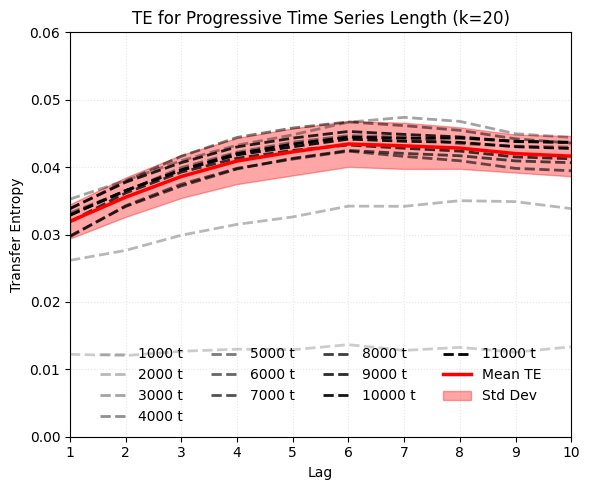

In [38]:
# plot results for study 3
plt.figure(figsize=(6, 5))
alphas = np.linspace(0.2, 1, len(size_list))
for size_idx in range(len(size_list)):
    plt.plot(lagList, te_progressive[size_idx, :], 
             label=f'{size_list[size_idx]} t', linewidth=2.0, 
             alpha=alphas[size_idx], linestyle='--',
             color='black')

# plot mean TE
mean_te = np.mean(te_progressive[1:,:], axis=0)
plt.plot(lagList, mean_te, label='Mean TE', color='red', linewidth=2.5, linestyle='-')
# plot standard deviation
std_te = np.std(te_progressive[1:,:], axis=0)
plt.fill_between(lagList, mean_te - std_te, mean_te + std_te,
                 color='red', alpha=0.35, label='Std Dev')

# plt.axhline(0, color='black', linewidth=1.0, linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Transfer Entropy')
plt.xlim([1, 10])
plt.ylim([0, 0.06])
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(ncols=4, fancybox=False, frameon=False, fontsize=10, loc='lower center')
plt.title(f'TE for Progressive Time Series Length (k={k_})')
plt.tight_layout()
plt.show()

In [39]:
# study 4: Progressive size with k - source[0] with target[1], but increasing section of timeseries selected, and k increases
def ksg_progressive_k(size_idx, lag_idx, lag, source_data, target_data, size, k_val, k_idx):
    te_val = bi_te(source_data[:size], target_data[:size], lag).ksg(k=k_val)
    return size_idx, lag_idx, size, k_idx, te_val

# size progression
min_step = 1000
max_step = 10000
size_step = 1000
step_list = list(range(min_step, max_step + 1, size_step))
    
# k progression
k_list = [3, 5, 7, 11, 15, 21, 31, 51, 71, 101]

print(len(step_list))
print(len(k_list))

print(f"Step progression: {min_step} -> {max_step} (step: {size_step})")
print(f"Step list: {step_list}")

start_idx = 0
end_idx = start_idx + max_step

source = patch_mode[start_idx:end_idx, 0]
target = patch_mode[start_idx:end_idx, 1]

tasks_study4 = [
    (size_idx, lag_idx, lag, source, target, size, k_, k_idx)
    for size_idx, size in enumerate(step_list)
    for lag_idx, lag in enumerate(lagList)
    for k_idx, k_ in enumerate(k_list)
]

print(f"Total tasks: {len(tasks_study4)}")

results_study4 = Parallel(n_jobs=-1)(
    delayed(ksg_progressive_k)(size_idx, lag_idx, lag, src_data, tgt_data, size, k_val, k_idx)
    for size_idx, lag_idx, lag, src_data, tgt_data, size, k_val, k_idx in tqdm(tasks_study4, desc='Study 4: Progressive size with k', unit='task')
)

te_progressive_k = np.zeros((len(step_list), len(k_list), len(lagList)))
for size_idx, lag_idx, size, k_idx, te_val in results_study4:
    te_progressive_k[size_idx, k_idx, lag_idx] = te_val

10
10
Step progression: 1000 -> 10000 (step: 1000)
Step list: [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
Total tasks: 1000


Study 4: Progressive size with k: 100%|██████████| 1000/1000 [07:54<00:00,  2.11task/s]


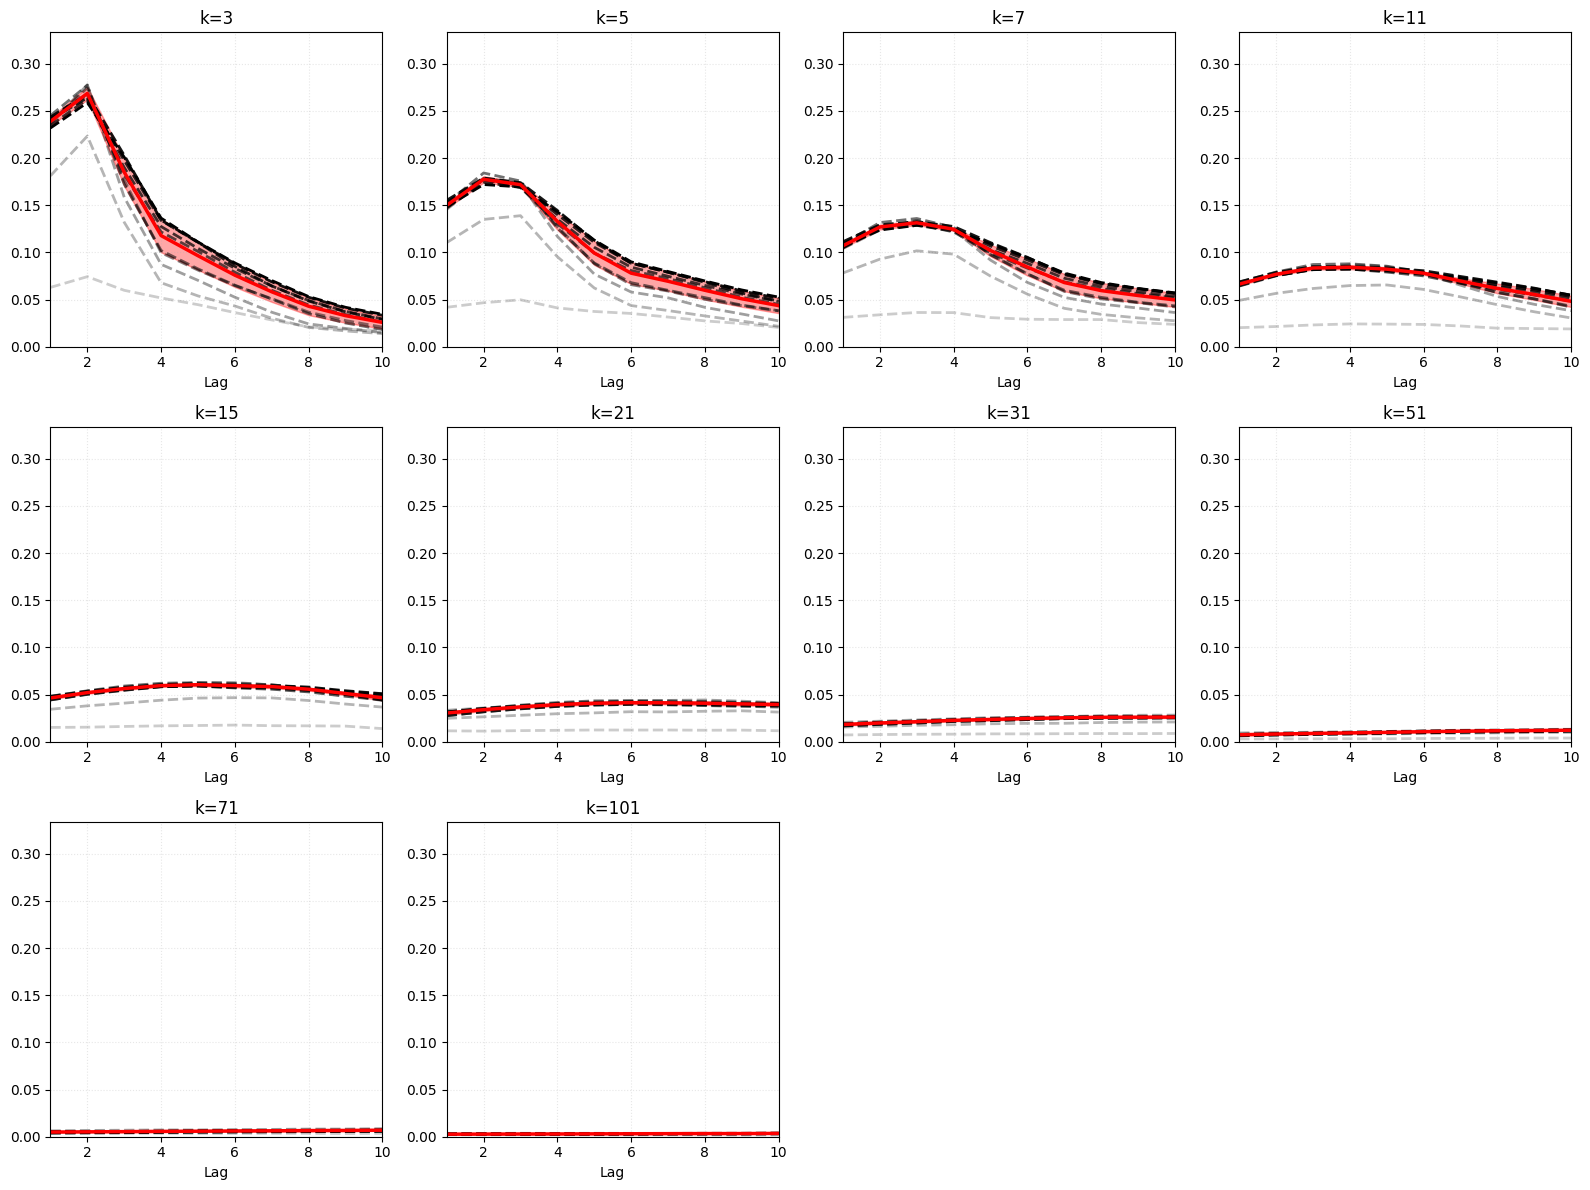

In [40]:
# make plot of TE vs lag for different k values
n_cols = 4
n_plots = len(k_list)
n_rows = int(np.ceil(n_plots / n_cols))

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)
alphas = np.linspace(0.2, 1, len(step_list))

for k_idx in range(len(k_list)):
    row = k_idx // n_cols
    col = k_idx % n_cols
    
    # Plot each time step
    for size_idx in range(len(step_list)):
        ax[row, col].plot(lagList, te_progressive_k[size_idx, k_idx, :], 
                        label=f'{step_list[size_idx]} t', 
                        linewidth=2.0, 
                        alpha=alphas[size_idx], 
                        linestyle='--', 
                        color='black')
        
    # Plot mean TE
    mean_te = np.mean(te_progressive_k[2:, k_idx, :], axis=0)
    ax[row, col].plot(lagList, mean_te, label='Mean TE', color='red', linewidth=2.5, linestyle='-')
    
    # Plot standard deviation
    std_te = np.std(te_progressive_k[2:, k_idx, :], axis=0)
    ax[row, col].fill_between(lagList, mean_te - std_te, mean_te + std_te,
                          color='red', alpha=0.35, label='Std Dev')
    
    # Conifgure subplot
    ax[row, col].set_title(f'k={k_list[k_idx]}')
    ax[row, col].set_xlabel('Lag')
    ax[row, col].set_xlim([1, 10])
    # ax[row, col].set_ylim([0, np.max(te_progressive_k[2:, k_idx, :]) * 1.2])
    ax[row, col].set_ylim([0, np.max(te_progressive_k[2:, :, :]) * 1.2])
    ax[row, col].grid(True, linestyle=':', alpha=0.3)
    
# Hide unused subplots
for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    ax[row, col].set_visible(False)    

plt.tight_layout()
# plt.legend(ncols=4, fancybox=False, frameon=False, fontsize=10, loc='lower center')
# plt.suptitle(f'Transfer Entropy for Progressive Time Series Length with Varying k', fontsize=14, y=1.02)
plt.show()

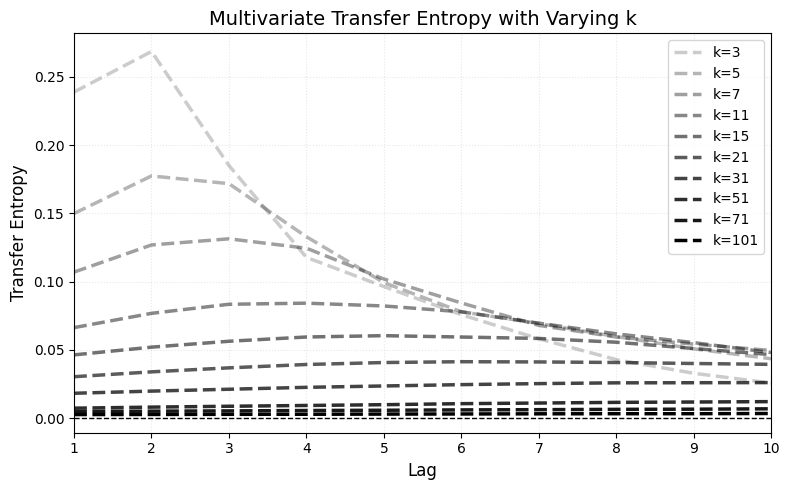

In [41]:
# plot means of TE for each k value on same plot
plt.figure(figsize=(8, 5))
alphas = np.linspace(0.2, 1, len(k_list))
for k_idx in range(len(k_list)):
    plt.plot(lagList, np.mean(te_progressive_k[2:, k_idx, :], axis=0), 
             label=f'k={k_list[k_idx]}', 
             linewidth=2.5, 
             color='black', 
             alpha=alphas[k_idx],
             linestyle='--')
    
plt.axhline(0, color='black', linewidth=1.0, linestyle='--')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Transfer Entropy', fontsize=12)
plt.title('Multivariate Transfer Entropy with Varying k', fontsize=14)
plt.xlim([1, 10])
# plt.ylim([0, 0.06])
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

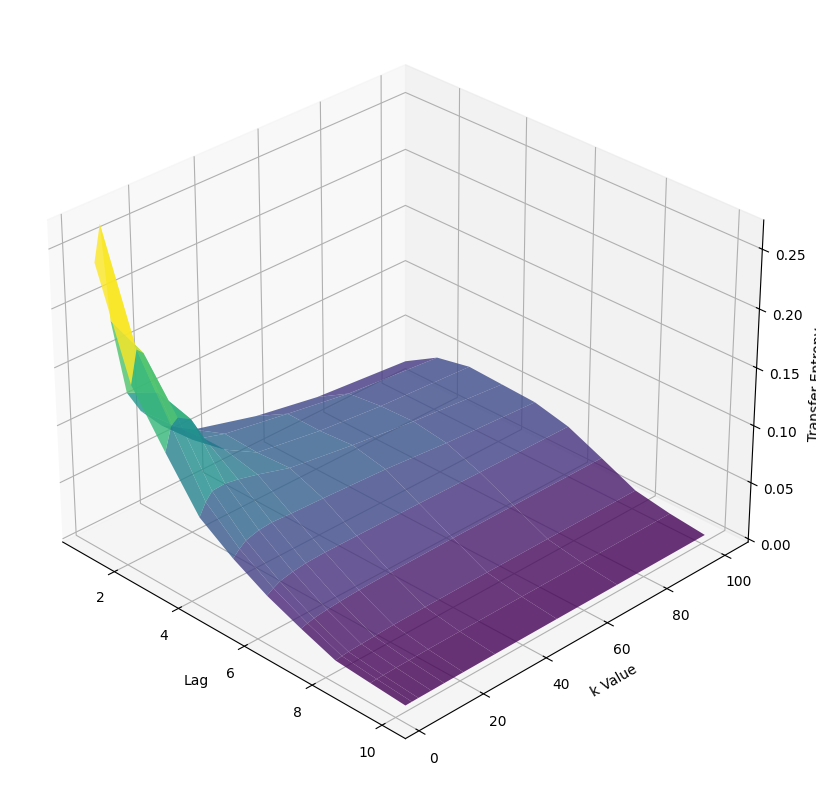

In [42]:
# 3d plot of TE vs lag and k
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(lagList, k_list)

Z = np.mean(te_progressive_k[2:, :, :], axis=0)
ax.plot_surface(X, Y, Z.T, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_xlabel('Lag')
ax.set_ylabel('k Value')
ax.set_zlabel('Transfer Entropy')
# ax.set_title('3D Surface Plot of Transfer Entropy vs Lag and k Value', fontsize=14)
ax.view_init(elev=30, azim=-45)  # Adjust view
# plt.tight_layout()
plt.show()

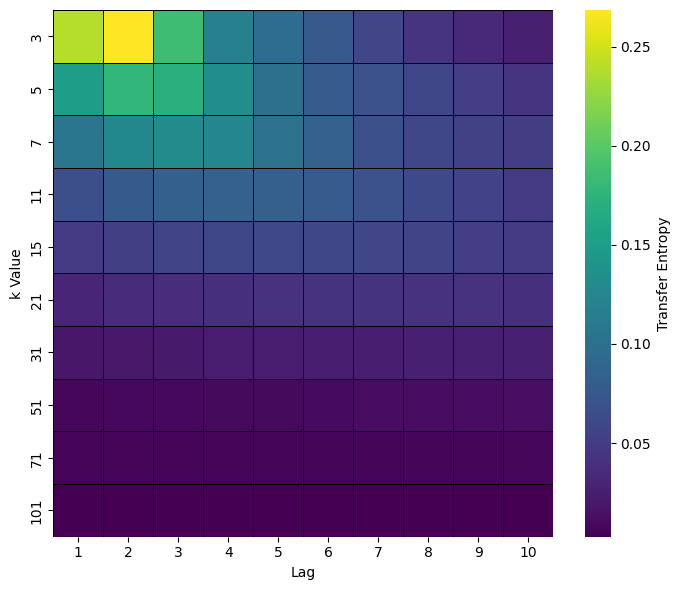

In [43]:
# heatmap of TE vs lag and k
import seaborn as sns
plt.figure(figsize=(7, 6))
sns.heatmap(np.mean(te_progressive_k[2:, :, :], axis=0), 
            annot=False, fmt=".4f", cmap='viridis',
            xticklabels=lagList, yticklabels=k_list,
            cbar_kws={'label': 'Transfer Entropy'},
            linewidths=0.5, linecolor='black')
# plt.title('Heatmap of Transfer Entropy vs Lag and k Value', fontsize=14)
plt.xlabel('Lag')
plt.ylabel('k Value')
plt.tight_layout()
plt.show()

In [50]:
# study 5: Progressive step size - source[0] with target[1], but subsampling the time series rather than just selecting a bigger portion
def ksg_subsample(step_idx, lag_idx, lag, source_data, target_data, step, k_):
    te_val = bi_te(source_data[::step], target_data[::step], lag).ksg(k=k_)
    return step_idx, lag_idx, step, te_val

# subsampling rates
min_step = 1
max_step = 10
step_list = list(range(min_step, max_step + 1))

max_size = 11000
start_idx = 0
end_idx = start_idx + max_size
source_data = patch_mode[start_idx:end_idx, 0]
target_data = patch_mode[start_idx:end_idx, 1]

print(f"Step progression: {min_step} -> {max_step}")
print(f"Step list: {step_list}")
print(f"Using data from index {start_idx} to {end_idx}")
print(f"Data lengths: source={len(source_data)}, target={len(target_data)}")

tasks_study5 = [
    (step_idx, lag_idx, lag, source_data, target_data, step, k_)
    for step_idx, step in enumerate(step_list)
    for lag_idx, lag in enumerate(lagList)
]

results_study5 = Parallel(n_jobs=-1)(
    delayed(ksg_subsample)(step_idx, lag_idx, lag, src_data, tgt_data, step, k_)
    for step_idx, lag_idx, lag, src_data, tgt_data, step, k_ in tqdm(tasks_study5, desc='Study 5: Progressive step size', unit='task')
)

te_subsample = np.zeros((len(step_list), len(lagList)))

for step_idx, lag_idx, step, te_val in results_study5:
    te_subsample[step_idx, lag_idx] = te_val

Step progression: 1 -> 10
Step list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Using data from index 0 to 11000
Data lengths: source=11000, target=11000


Study 5: Progressive step size: 100%|██████████| 100/100 [00:22<00:00,  4.45task/s]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]


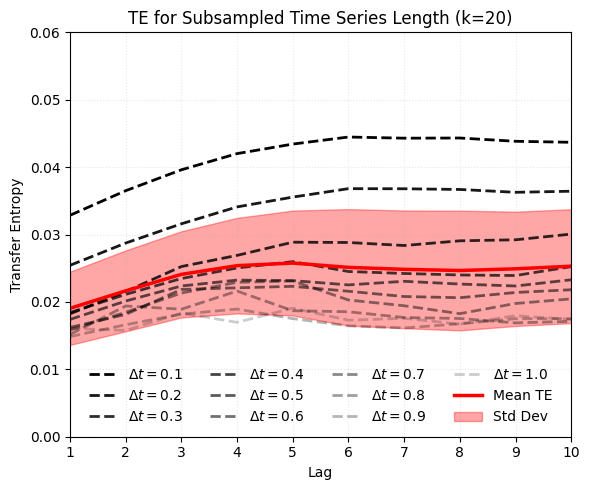

In [51]:
# plot results for study 5
delta_t = 0.1
delta_t_list = [0.1*step for step in step_list]
print(step_list)
print(delta_t_list)

plt.figure(figsize=(6, 5))
alphas = np.linspace(1.0, 0.2, len(step_list))
for step_idx in range(len(step_list)):
    plt.plot(lagList, te_subsample[step_idx, :], 
             label=rf'$\Delta t = ${delta_t_list[step_idx]:.1f}', linewidth=2.0, 
             alpha=alphas[step_idx], linestyle='--',
             color='black')

# plot mean TE
mean_te = np.mean(te_subsample[:,:], axis=0)
plt.plot(lagList, mean_te, label='Mean TE', color='red', linewidth=2.5, linestyle='-')
# plot standard deviation
std_te = np.std(te_subsample[:,:], axis=0)
plt.fill_between(lagList, mean_te - std_te, mean_te + std_te,
                 color='red', alpha=0.35, label='Std Dev')

plt.xlabel('Lag')
plt.ylabel('Transfer Entropy')
plt.xlim([1, 10])
plt.ylim([0, 0.06])
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(ncols=4, fancybox=False, frameon=False, fontsize=10, loc='lower center')
plt.title(f'TE for Subsampled Time Series Length (k={k_})')
plt.tight_layout()
plt.show()